In [2]:
from pathlib import Path
import sys

# 1. Calcula la carpeta padre del notebook
parent_dir = Path().resolve().parent

# 2. Inserta esa ruta al principio de sys.path
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

# 3. Ahora ya puedes importar
from variables import *

## Cuadrícula de boxplots

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1. Load and clean data
csv_path = "all_models_scores_clean.csv"  # adjust path if needed
df = pd.read_csv(csv_path).dropna(subset=["Scope", "Country"] +
    [f"{m}_subjectivity" for m in ["DeepSeek","Gemini","Llama","Phi","ChatGPT"]])

# 2. Prepare variables
scopes    = sorted(df["Scope"].unique())
countries = sorted(df["Country"].unique())
models    = ["DeepSeek","Gemini","Llama","Phi","ChatGPT"]

# 3. Base pastel colors (RGB tuples)
base_colors = {
    "DeepSeek": (0.4,0.6,0.8),
    "Gemini":   (0.9,0.6,0.4),
    "Llama":    (0.6,0.8,0.6),
    "Phi":      (0.9,0.5,0.5),
    "ChatGPT":  (0.7,0.5,0.8)
}

# 4. Create grid: rows = countries, cols = scopes
n_rows, n_cols = len(countries), len(scopes)
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols*1.3, n_rows*1.3),
                         sharex=False, sharey=False)

# 5. Plot each cell
for i, country in enumerate(countries):
    for j, scope in enumerate(scopes):
        ax = axes[i, j]
        subset = df[(df["Country"]==country)&(df["Scope"]==scope)]
        if subset.empty:
            ax.axis('off')
            continue

        # compute objectivity means and baseline
        obj = {m: 1 - subset[f"{m}_subjectivity"].mean() for m in models}
        baseline = np.mean(list(obj.values()))

        # draw bars with alpha mapping
        for k, m in enumerate(models):
            val   = obj[m]
            diff  = val - baseline
            bot   = baseline if diff >= 0 else val
            height= abs(diff)
            color = base_colors[m]
            alpha = 0.2 + 0.8 * val
            ax.bar(k, height, bottom=bot, color=color, alpha=alpha, width=0.8)

        # enforce fixed data range 0–1 and add margins on both sides
        ax.set_ylim(0, 1)  # 0–1 data plus 0.2 margin above and below
        ax.set_xlim(-0.5 - 0.5, len(models)-0.5 + 0.5)  # add 0.2 margin left/right

        ax.set_xticks([]); ax.set_yticks([])

        # draw thin grey border around cell
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('lightgrey')
            spine.set_linewidth(0.8)

        # row label (country) at left
        if j == 0:
            ax.text(-0.3, 0.5, country, transform=ax.transAxes,
                    rotation=0, va='center', ha='right', fontsize=12)
        # column label (scope) at bottom
        if i == n_rows-1:
            ax.text(0.5, -0.3, scope, transform=ax.transAxes,
                    rotation=0, va='top', ha='center', fontsize=12)

# 6. Tighten borders between cells
plt.subplots_adjust(wspace=0, hspace=0, right=0.85, bottom=0.1)

# 7. Global legend at right
handles = [mpatches.Patch(color=base_colors[m], label=m) for m in models]
fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.02,0.5),
           frameon=False, title="Model", fontsize=12)

# 8. Save as PDF
os.makedirs("output/barplots", exist_ok=True)
fig.savefig("output/barplots/scope_country_objectivity_grid.pdf",
            format='pdf', bbox_inches='tight')
plt.close(fig)


Por tonalidad ahora

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1. Cargar datos limpios
csv_path = "all_models_scores_clean.csv"
df = pd.read_csv(csv_path).dropna(subset=["Scope", "Country"] +
    [f"{m}_sent_compound" for m in ["DeepSeek","Gemini","Llama","Phi","ChatGPT"]])

# 2. Definir ámbitos, países y modelos
scopes    = sorted(df["Scope"].unique())
countries = sorted(df["Country"].unique())
models    = ["DeepSeek","Gemini","Llama","Phi","ChatGPT"]

# 3. Colores base pastel
base_colors = {
    "DeepSeek": (0.4,0.6,0.8),
    "Gemini":   (0.9,0.6,0.4),
    "Llama":    (0.6,0.8,0.6),
    "Phi":      (0.9,0.5,0.5),
    "ChatGPT":  (0.7,0.5,0.8)
}

# 4. Crear grid de subplots
n_rows, n_cols = len(countries), len(scopes)
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols*1.3, n_rows*1.3),
                         sharex=False, sharey=False)

# 5. Rellenar cada celda
for i, country in enumerate(countries):
    for j, scope in enumerate(scopes):
        ax = axes[i, j]
        subset = df[(df["Country"]==country) & (df["Scope"]==scope)]
        if subset.empty:
            ax.axis('off')
            continue

        # 5a. Extraer medias de sent_compound y normalizar a [0,1]
        norms = {}
        for m in models:
            raw = subset[f"{m}_sent_compound"].mean()
            norms[m] = (raw + 1)/2   # de [-1,1] a [0,1]

        # 5b. Cálculo de baseline (media normalizada)
        baseline = np.mean(list(norms.values()))

        # 5c. Dibujar barras: desviación respecto al baseline
        for k, m in enumerate(models):
            val   = norms[m]
            diff  = val - baseline
            # Si diff>=0, barra desde baseline hacia arriba
            # Si diff<0, barra desde val hacia abajo
            bottom = baseline if diff >= 0 else val
            height = abs(diff)
            color  = base_colors[m]
            ax.bar(k, height, bottom=bottom,
                   color=color, alpha=0.8, width=0.8)

        # 5d. Ajustes de eje Y para rango [0,1] con margen
        y_pad = 0.33
        x_pad = 0.3
        ax.set_ylim(0 - y_pad, 1 + y_pad)
        ax.set_xlim(-0.5 - x_pad, len(models) - 0.5 + x_pad)
        ax.set_xticks([]); ax.set_yticks([])

        # 5e. Bordes grises finos
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('lightgrey')
            spine.set_linewidth(0.8)

        # 5f. Etiquetas de fila/columna
        if j == 0:
            ax.text(-0.3, 0.5, country, transform=ax.transAxes,
                    va='center', ha='right', fontsize=10)
        if i == n_rows - 1:
            ax.text(0.5, -0.3, scope, transform=ax.transAxes,
                    va='top', ha='center', fontsize=10)

# 6. Espaciado y leyenda común
plt.subplots_adjust(wspace=0, hspace=0, right=0.85, bottom=0.1)
handles = [mpatches.Patch(color=base_colors[m], label=m) for m in models]
fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.02,0.5),
           frameon=False, title="Model")

# 7. Guardar PDF
os.makedirs("output/barplots", exist_ok=True)
out_path = "output/barplots/scope_country_tone_grid.pdf"
fig.savefig(out_path, format='pdf', bbox_inches='tight')
plt.close(fig)


## Análisis SANKEY de políticos de países

In [20]:
import pandas as pd
import os

# 1. Cargar datos
df = pd.read_csv("all_models_scores_clean.csv")

# 2. Países de estudio y columna de ChatGPT_sent_compound
countries = ["United States", "Russia", "China", "Brasil", "France"]
col = "Phi_sent_compound"

# 3. Filtrar solo políticos de esos países
politicians = df[(df["Scope"] == "Politician") & (df["Country"].isin(countries))]

# 4. Clasificar sentimental con cortes
bins = [-1.0, -0.5, 0.5, 1.0]
labels = ["Negative", "Neutral", "Positive"]
politicians["SentimentClass"] = pd.cut(
    politicians[col],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# 5. Contar casos por país y clase
counts = politicians.groupby(["Country", "SentimentClass"]).size().unstack(fill_value=0)


# 6. Guardar CSV
os.makedirs("output/csv", exist_ok=True)
csv_path = "output/csv/phi_politician_country_sentiment.csv"
counts.to_csv(csv_path, encoding="utf-8")

print("Conteos por país y clase:")
print(counts)
print(f"\nCSV guardado en: {csv_path}")

Conteos por país y clase:
SentimentClass  Negative  Neutral  Positive
Country                                    
Brasil                 4        2        11
China                  3        3        14
France                 0        2        19
Russia                 4        6        11
United States          2        3        16

CSV guardado en: output/csv/phi_politician_country_sentiment.csv


C:\Users\aleja\AppData\Local\Temp\ipykernel_21712\409363663.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  politicians["SentimentClass"] = pd.cut(
C:\Users\aleja\AppData\Local\Temp\ipykernel_21712\409363663.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = politicians.groupby(["Country", "SentimentClass"]).size().unstack(fill_value=0)


In [12]:
import pandas as pd
import os

# 1. Cargar datos
df = pd.read_csv("all_models_scores_clean.csv")

# 2. Países de estudio y columna de ChatGPT_sent_compound
countries = ["United States", "Russia", "China", "Brasil", "France"]
col = "DeepSeek_sent_compound"

# 3. Filtrar solo políticos de esos países
politicians = df[(df["Scope"] == "Politician") & (df["Country"].isin(countries))]

# 4. Clasificar sentimental con cortes
bins = [-1.0, -0.5, 0.5, 1.0]
labels = ["Negative", "Neutral", "Positive"]
politicians["SentimentClass"] = pd.cut(
    politicians[col],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# 5. Contar casos por país y clase
counts = politicians.groupby(["Country", "SentimentClass"]).size().unstack(fill_value=0)


# 6. Guardar CSV
os.makedirs("output/csv", exist_ok=True)
csv_path = "output/csv/deepseek_politician_country_sentiment.csv"
counts.to_csv(csv_path, encoding="utf-8")

print("Conteos por país y clase:")
print(counts)
print(f"\nCSV guardado en: {csv_path}")

Conteos por país y clase:
SentimentClass  Negative  Neutral  Positive
Country                                    
Brasil                 5        4         8
China                  7        3        10
France                 3        8        10
Russia                 8        3        10
United States          3        4        14

CSV guardado en: output/csv/deepseek_politician_country_sentiment.csv


C:\Users\aleja\AppData\Local\Temp\ipykernel_696\4263953721.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  politicians["SentimentClass"] = pd.cut(
C:\Users\aleja\AppData\Local\Temp\ipykernel_696\4263953721.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = politicians.groupby(["Country", "SentimentClass"]).size().unstack(fill_value=0)


In [ ]:
import pandas as pd

df = pd.read_csv(".csvall_models_scores_clean")

## Objetividad media

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Leer datos
df = pd.read_csv("all_models_scores_clean.csv")

# 2. Columnas de subjetividad y colores
subjectivity_cols = {
    "ChatGPT":  "ChatGPT_subjectivity",
    "DeepSeek": "DeepSeek_subjectivity",
    "Gemini":   "Gemini_subjectivity",
    "Phi":      "Phi_subjectivity",
    "Llama":    "Llama_subjectivity"
}
colors = {
    "ChatGPT":  (0.7, 0.5, 0.8),
    "DeepSeek": (0.4, 0.6, 0.8),
    "Gemini":   (0.9, 0.6, 0.4),
    "Phi":      (0.9, 0.5, 0.5),
    "Llama":    (0.6, 0.8, 0.6)
}

# 3. Calcular objectividad y estadísticas
stats = []
for model, col in subjectivity_cols.items():
    obj = 1 - df[col]
    stats.append({
        "Model": model,
        "Mean": obj.mean(),
        "Std":  obj.std()
    })
df_stats = pd.DataFrame(stats)

# 4. Dibujar cada punto + barra de error individualmente
fig, ax = plt.subplots(figsize=(6,4))
for idx, row in df_stats.iterrows():
    m = row["Model"]
    mean = row["Mean"]
    std  = row["Std"]
    ax.errorbar(
        idx, mean, yerr=std,
        fmt='o',
        color=colors[m],
        ecolor=colors[m],
        capsize=5,
        markersize=8,
    )

# 5. Ajustes de ejes
ax.set_xticks(range(len(df_stats)))
ax.set_xticklabels(df_stats["Model"], rotation=45, ha='right')
ax.set_ylabel("Objectivity (mean ± std)")
ax.set_ylim(0,1)
plt.tight_layout()

# 6. Guardar
os.makedirs("output/figures", exist_ok=True)
fig.savefig("output/figures/objectivity_errorbar_by_model.pdf", format="pdf", bbox_inches="tight")
plt.close(fig)


In [11]:
df_stats.to_csv("output/csv/objectivity_stats_by_model.csv", index=False)

## Tonalidad media

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Leer el CSV con sent_compound
df = pd.read_csv("all_models_scores_clean.csv")

# 2. Columnas de sent_compound y colores
sentiment_cols = {
    "ChatGPT":  "ChatGPT_sent_compound",
    "DeepSeek": "DeepSeek_sent_compound",
    "Gemini":   "Gemini_sent_compound",
    "Phi":      "Phi_sent_compound",
    "Llama":    "Llama_sent_compound"
}
colors = {
    "ChatGPT":  (0.7, 0.5, 0.8),
    "DeepSeek": (0.4, 0.6, 0.8),
    "Gemini":   (0.9, 0.6, 0.4),
    "Phi":      (0.9, 0.5, 0.5),
    "Llama":    (0.6, 0.8, 0.6)
}

# 3. Calcular media de sent_compound por modelo
stats = []
for model, col in sentiment_cols.items():
    mean_val = df[col].mean()
    stats.append({
        "Model": model,
        "Mean_SentCompound": mean_val
    })
df_stats = pd.DataFrame(stats)

# 4. Guardar CSV de medias
os.makedirs("output/csv", exist_ok=True)
csv_path = "output/csv/sentiment_compound_means.csv"
df_stats.to_csv(csv_path, index=False, encoding="utf-8")
print(f"Means saved to {csv_path}")

# 5. Graficar barras
fig, ax = plt.subplots(figsize=(6,4))
models = df_stats["Model"]
means  = df_stats["Mean_SentCompound"]
bar_colors = [colors[m] for m in models]

ax.bar(models, means, color=bar_colors)
ax.set_ylabel("Mean Sentiment Compound")
ax.set_ylim(-1, 1)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# 6. Guardar gráfico en PDF
os.makedirs("output/figures", exist_ok=True)
fig_path = "output/figures/sentiment_compound_means.pdf"
fig.savefig(fig_path, format="pdf", bbox_inches="tight")
plt.close(fig)
print(f"Figure saved to {fig_path}")


Means saved to output/csv/sentiment_compound_means.csv
Figure saved to output/figures/sentiment_compound_means.pdf


## Desviación del promedio en tonalidad (sent_compound)

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Leer los datos
df = pd.read_csv("all_models_scores_clean.csv")

# 2. Definir los modelos y sus columnas de sent_compound
models = {
    "ChatGPT": "ChatGPT_sent_compound",
    "Gemini":  "Gemini_sent_compound",
    "Llama":   "Llama_sent_compound",
    "Phi":     "Phi_sent_compound",
    "DeepSeek":"DeepSeek_sent_compound"
}

# 3. Calcular la media global
all_values = pd.concat([df[col] for col in models.values()], ignore_index=True)
global_mean = all_values.mean()

# 4. Calcular la media y desviación por modelo
results = []
for name, col in models.items():
    mean_val = df[col].mean()
    deviation = abs(mean_val - global_mean)
    results.append({"Model": name, "Mean": mean_val, "Deviation": deviation})

df_results = pd.DataFrame(results)

# 5. Guardar en CSV
os.makedirs("output/csv", exist_ok=True)
csv_path = "output/csv/sent_compound_deviations.csv"
df_results.to_csv(csv_path, index=False, encoding="utf-8")
print(f"CSV saved to {csv_path}")

# 6. Graficar desviaciones
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(df_results["Model"], df_results["Deviation"], color="skyblue")
ax.axhline(0, color="gray", linewidth=0.8)
ax.set_xlabel("Model")
ax.set_ylabel("Deviation from Global Mean")
ax.set_title("Deviation of sent_compound by Model")
plt.tight_layout()

# 7. Guardar gráfico
os.makedirs("output/figures", exist_ok=True)
fig_path = "output/figures/sent_compound_deviations.pdf"
fig.savefig(fig_path, format="pdf", bbox_inches="tight")
plt.close(fig)
print(f"Figure saved to {fig_path}")


CSV saved to output/csv/sent_compound_deviations.csv
Figure saved to output/figures/sent_compound_deviations.pdf


## Proporción media de los componentes positivo, neutro y negativo de la tonalidad para cada modelo

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Leer los datos
df = pd.read_csv("all_models_scores_clean.csv")

# 2. Definir los modelos y sus columnas de sent_compound
models = {
    "ChatGPT": "ChatGPT_sent_compound",
    "Gemini":  "Gemini_sent_compound",
    "Llama":   "Llama_sent_compound",
    "Phi":     "Phi_sent_compound",
    "DeepSeek":"DeepSeek_sent_compound"
}

# Colores base en RGB
base_colors = {
    "DeepSeek": (0.4, 0.6, 0.8),
    "Gemini":   (0.9, 0.6, 0.4),
    "Llama":    (0.6, 0.8, 0.6),
    "Phi":      (0.9, 0.5, 0.5),
    "ChatGPT":  (0.7, 0.5, 0.8)
}

# 3. Calcular la media global
all_values = pd.concat([df[col] for col in models.values()], ignore_index=True)
global_mean = all_values.mean()

# 4. Calcular la media y desviación por modelo
results = []
for name, col in models.items():
    mean_val = df[col].mean()
    deviation = mean_val - global_mean
    results.append({"Model": name, "Mean": mean_val, "Deviation": deviation})

df_results = pd.DataFrame(results)

# 5. Guardar en CSV
os.makedirs("output/csv", exist_ok=True)
csv_path = "output/csv/sent_compound_deviations.csv"
df_results.to_csv(csv_path, index=False, encoding="utf-8")

# 6. Graficar desviaciones con colores base
fig, ax = plt.subplots(figsize=(8, 4))
colors = [base_colors[name] for name in df_results["Model"]]
ax.bar(df_results["Model"], df_results["Deviation"], color=colors)
ax.axhline(0, color="gray", linewidth=0.8)
ax.set_xlabel("Model")
ax.set_ylabel("Deviation from Global Mean")
ax.set_title("Deviation of sent_compound by Model")
plt.tight_layout()

# 7. Guardar gráfico
os.makedirs("output/figures", exist_ok=True)
fig_path = "output/figures/sent_compound_deviations.pdf"
fig.savefig(fig_path, format="pdf", bbox_inches="tight")
plt.close(fig)

print(f"CSV saved to {csv_path}")
print(f"Figure saved to {fig_path}")

CSV saved to output/csv/sent_compound_deviations.csv
Figure saved to output/figures/sent_compound_deviations.pdf


## Araña global

In [3]:
import pandas as pd
import os

# 1. Ruta al CSV con las columnas de subjectivity
INPUT_CSV = "all_models_scores_clean.csv"  # ajusta ruta si es necesario
OUTPUT_DIR = "output/csv"
OUTPUT_CSV = os.path.join(OUTPUT_DIR, "objectivity_means.csv")

# 2. Definir los modelos y sus columnas de subjectivity
models = {
    "ChatGPT": "ChatGPT_subjectivity",
    "Gemini":  "Gemini_subjectivity",
    "Llama":   "Llama_subjectivity",
    "Phi":     "Phi_subjectivity",
    "DeepSeek":"DeepSeek_subjectivity"
}

# 3. Leer el CSV
df = pd.read_csv(INPUT_CSV)

# 4. Calcular objectivity = 1 - subjectivity y luego la media por modelo
results = []
for name, subj_col in models.items():
    # Creamos la serie de objectivity
    obj_series = 1.0 - df[subj_col]
    # Calculamos su media
    mean_obj = obj_series.mean()
    results.append({
        "Model": name,
        "Mean_Objectivity": mean_obj
    })

df_out = pd.DataFrame(results)

# 5. Guardar el CSV de objectivity means
os.makedirs(OUTPUT_DIR, exist_ok=True)
df_out.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")

print(f"Objectivity means saved to {OUTPUT_CSV}")


Objectivity means saved to output/csv\objectivity_means.csv


Longitud media de los textos

In [28]:
import pandas as pd

df_bios = pd.read_csv("../Capítulo Segundo/biografias_raw_corrected.csv")
# suponiendo que cada columna de modelo en df_bios es el texto de la bio
models = ["openai/gpt-4o-mini","deepseek/deepseek-chat-v3-0324",
          "google/gemini-2.0-flash-001","microsoft/phi-4-multimodal-instruct",
          "meta-llama/llama-4-maverick"]
lengths = {}
for m in models:
    col = m  # nombre exacto de la columna
    lengths[m] = df_bios[col].dropna().str.len().mean()

In [30]:
lengths_df = pd.DataFrame(lengths.items(), columns=["Model", "Avg_Length"])
lengths_df

,Model,Avg_Length
0,openai/gpt-4o-mini,1636.973589
1,deepseek/deepseek-chat-v3-0324,1229.390244
2,google/gemini-2.0-flash-001,1461.542317
3,microsoft/phi-4-multimodal-instruct,2005.181573
4,meta-llama/llama-4-maverick,1397.716327


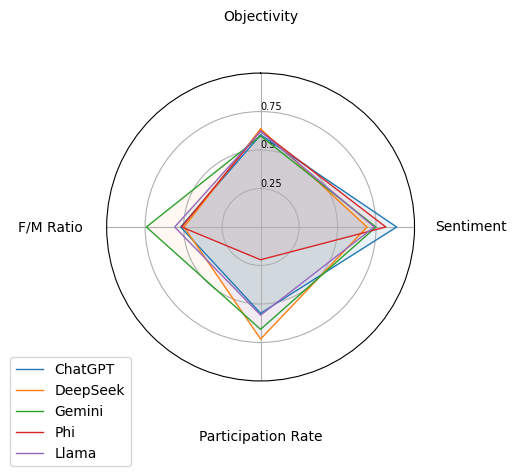

In [26]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
df = pd.DataFrame({
	'group': ['ChatGPT','DeekSeep','Gemini','Phi','Llama'],
	'Objectivity': 			[0.5985, 0.6376, 0.5914, 0.6239, 0.6213],
	'Sentiment': 			[0.884,  0.6915, 0.7499, 0.8137, 0.7383],
	'Participation Rate': 	[0.5608, 0.7277, 0.6648, 0.2128, 0.5723],
	'F/M Ratio': 			[0.5194, 0.4973, 0.7421, 0.5134, 0.5582]
})
 
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75], ["0.25","0.5","0.75"], color="black", size=7)
plt.ylim(0,1)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="ChatGPT")
ax.fill(angles, values, 'p', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="DeepSeek")
ax.fill(angles, values, 'b', alpha=0.05)

values=df.loc[2].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Gemini")
ax.fill(angles, values, 'o', alpha=0.05)

values=df.loc[3].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Phi")
ax.fill(angles, values, 'r', alpha=0.05)

values=df.loc[4].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Llama")
ax.fill(angles, values, 'g', alpha=0.05)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Mover etiquetas del eje X hacia afuera
ax.tick_params(axis='x', pad=30)

# Guardar en PDF
plt.tight_layout()
plt.savefig("output/figures/models_radar.pdf", format="pdf", bbox_inches="tight")

# Show the graph
plt.show()

## Red de conexiones de palabras

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
import community as louvain
import os

# 1) Carga datos completos
df_scores = pd.read_csv("all_models_scores_clean.csv", encoding="utf-8")
df_bios   = pd.read_csv("../Capítulo Segundo/biografias_raw_corrected.csv",  encoding="utf-8")

# 2) Filtrar solo atletas

df = pd.merge(
    df_bios,
    df_scores[["Name","Scope"]].drop_duplicates(),
    on="Name",
    how="inner"    # sólo biografías que tengan match en scores
)

df_athletes = df[df["Scope"] == "Athlete"]


# 3) Define cómo parsear tu columna de top-5 keywords
#    (ajusta el nombre de tu columna real si difiere)
kw_cols = {
    "ChatGPT":  "ChatGPT_top5_keywords",
    "DeepSeek": "DeepSeek_top5_keywords",
    "Gemini":   "Gemini_top5_keywords",
    "Phi":      "Phi_top5_keywords",
    "Llama":    "Llama_top5_keywords"
}

def parse_kw(cell):
    return [w.strip() for w in str(cell).split(",") if w.strip()]

# 4) Construir listas de keywords solo para atletas
model_kw_lists = {}
for model, col in kw_cols.items():
    model_kw_lists[model] = ath_kw[col].apply(parse_kw).tolist()

# from rake_nltk import Rake
# r = Rake()
# def top_rake(text, n=5):
#     r.extract_keywords_from_text(text or "")
#     return [kw for kw,_ in r.get_ranked_phrases_with_scores()[:n]]
# for m in model_kw_lists:
#     enriched = []
#     for base_kw, text in zip(model_kw_lists[m], ath_bio[kw_cols[m]]):
#         enriched.append(list(set(base_kw + top_rake(text))))
#     model_kw_lists[m] = enriched

# 6) Contar co-ocurrencias por modelo (pares)
model_pair_counts = {}
for model, lists in model_kw_lists.items():
    cnt = Counter()
    for kws in lists:
        for a,b in combinations(sorted(set(kws)), 2):
            cnt[(a,b)] += 1
    # opcional: filtrar pares con peso < 2
    model_pair_counts[model] = {pair:w for pair,w in cnt.items() if w>=2}

# 7) Analizar y dibujar para cada modelo
os.makedirs("output/figures/athlete_networks", exist_ok=True)
stats = []
for model, cnt in model_pair_counts.items():
    G = nx.Graph()
    for (u,v), w in cnt.items():
        G.add_edge(u, v, weight=w)
    density = nx.density(G)
    partition = louvain.best_partition(G, weight="weight")
    stats.append({"Model": model, "Density": density, "Communities": len(set(partition.values()))})

    # Layout y dibujo
    pos = nx.spring_layout(G, weight="weight", seed=42)
    plt.figure(figsize=(8,8))
    nx.draw_networkx_nodes(
        G, pos,
        node_size=[50+10*G.degree(n) for n in G.nodes()],
        node_color=[partition[n] for n in G.nodes()],
        cmap="tab20", alpha=0.8
    )
    nx.draw_networkx_edges(
        G, pos,
        width=[G[u][v]["weight"]*0.2 for u,v in G.edges()],
        alpha=0.6
    )
    nx.draw_networkx_labels(G, pos, font_size=7)
    plt.title(f"Co-occurrence Network — {model} (Athletes)")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"output/figures/athlete_networks/{model}_athletes.pdf")
    plt.close()

# 8) Guardar métricas de red
pd.DataFrame(stats).to_csv("output/csv/athlete_network_stats.csv", index=False)


In [88]:
df_athletes

,Name,openai/gpt-4o-mini,deepseek/deepseek-chat-v3-0324,google/gemini-2.0-flash-001,microsoft/phi-4-multimodal-instruct,meta-llama/llama-4-maverick,Scope
0,Hitomi Kinue,"Hitomi Kinue, born on February 11, 1947, in Kō...",Hitomi Kinue (1907–1931) was a pioneering Japa...,Hitomi Kinue (1907-1931) was a pioneering Japa...,Hitomi Kinue (born 1963) is a renowned Japanes...,Here is a 300-word biography of Hitomi Kinue i...,Athlete
1,Kazumi Watanabe,"Kazumi Watanabe, born on March 5, 1954, in Yok...","Kazumi Watanabe, born on October 14, 1953, in ...",Kazumi Watanabe is a highly influential Japane...,Kazumi Watanabe (1912–2010) was a Japanese wri...,Kazumi Watanabe is a renowned Japanese guitari...,Athlete
2,Masako Chiba,"Masako Chiba, born in 1952 in Tokyo, Japan, is...",Masako Chiba (born 1970) is a celebrated Japan...,Masako Chiba is a Japanese author celebrated f...,Masako Chiba (born 1948) is a renowned Japanes...,Masako Chiba is a Japanese writer and survivor...,Athlete
3,Naoko Takahashi,"Naoko Takahashi, born on April 6, 1969, in the...","Naoko Takahashi, born on May 6, 1978, in Gifu,...","Naoko Takahashi, affectionately known as ""Q-ch...","Naoko Takahashi, born on December 1, 1959, in ...",Naoko Takahashi is a renowned Japanese long-di...,Athlete
4,Yuko Arimori,"Yuko Arimori, born on March 15, 1969, in Fukuy...","Yuko Arimori, born December 17, 1966, in Okaya...",Yuko Arimori is a celebrated Japanese marathon...,"Yuko Arimori, born Yuko Arinori Arimori in 195...",Yuko Arimori is a renowned Japanese long-dista...,Athlete
...,...,...,...,...,...,...,...
348,Carolina Marin,"Carolina Marín, born on June 15, 1993, in Huel...","Carolina Marín, born on June 15, 1993, in Huel...","Carolina Marín, born in Huelva, Spain, in 1993...","Carolina Marin (born December 12, 2001, in Gir...",Carolina Marín's rise to badminton stardom beg...,Athlete
349,Garbiñe Muguruza,"Garbiñe Muguruza, born on October 8, 1993, in ...","Garbiñe Muguruza, born1993199319931993, in Car...","Garbiñe Muguruza, born in Caracas, Venezuela, ...","Garbiñe Muguruza Nuria, born on March 16, 1993...","Garbiñe Muguruza was born on October 8, 1993, ...",Athlete
350,Lydia Valentín,"Lydia Valentín, born on February 10, 1985, in ...","Lydia Valentín Pérez, born on February 10, 198...",Lydia Valentín is a renowned Spanish weightlif...,"Lydia Valentín, born Lydia Martiño de Paz in 1...",Lydia Valentín is a renowned Spanish weightlif...,Athlete
351,Joe DiMaggio,"Joe DiMaggio, born on November 25, 1914, in Ma...","Joe DiMaggio, born Giuseppe Paolo DiMaggio on ...","Joe DiMaggio, born Giuseppe Paolo DiMaggio in ...","Joe DiMaggio, born in 1914 in Martinez, Califo...",Joe DiMaggio was a legendary American baseball...,Athlete


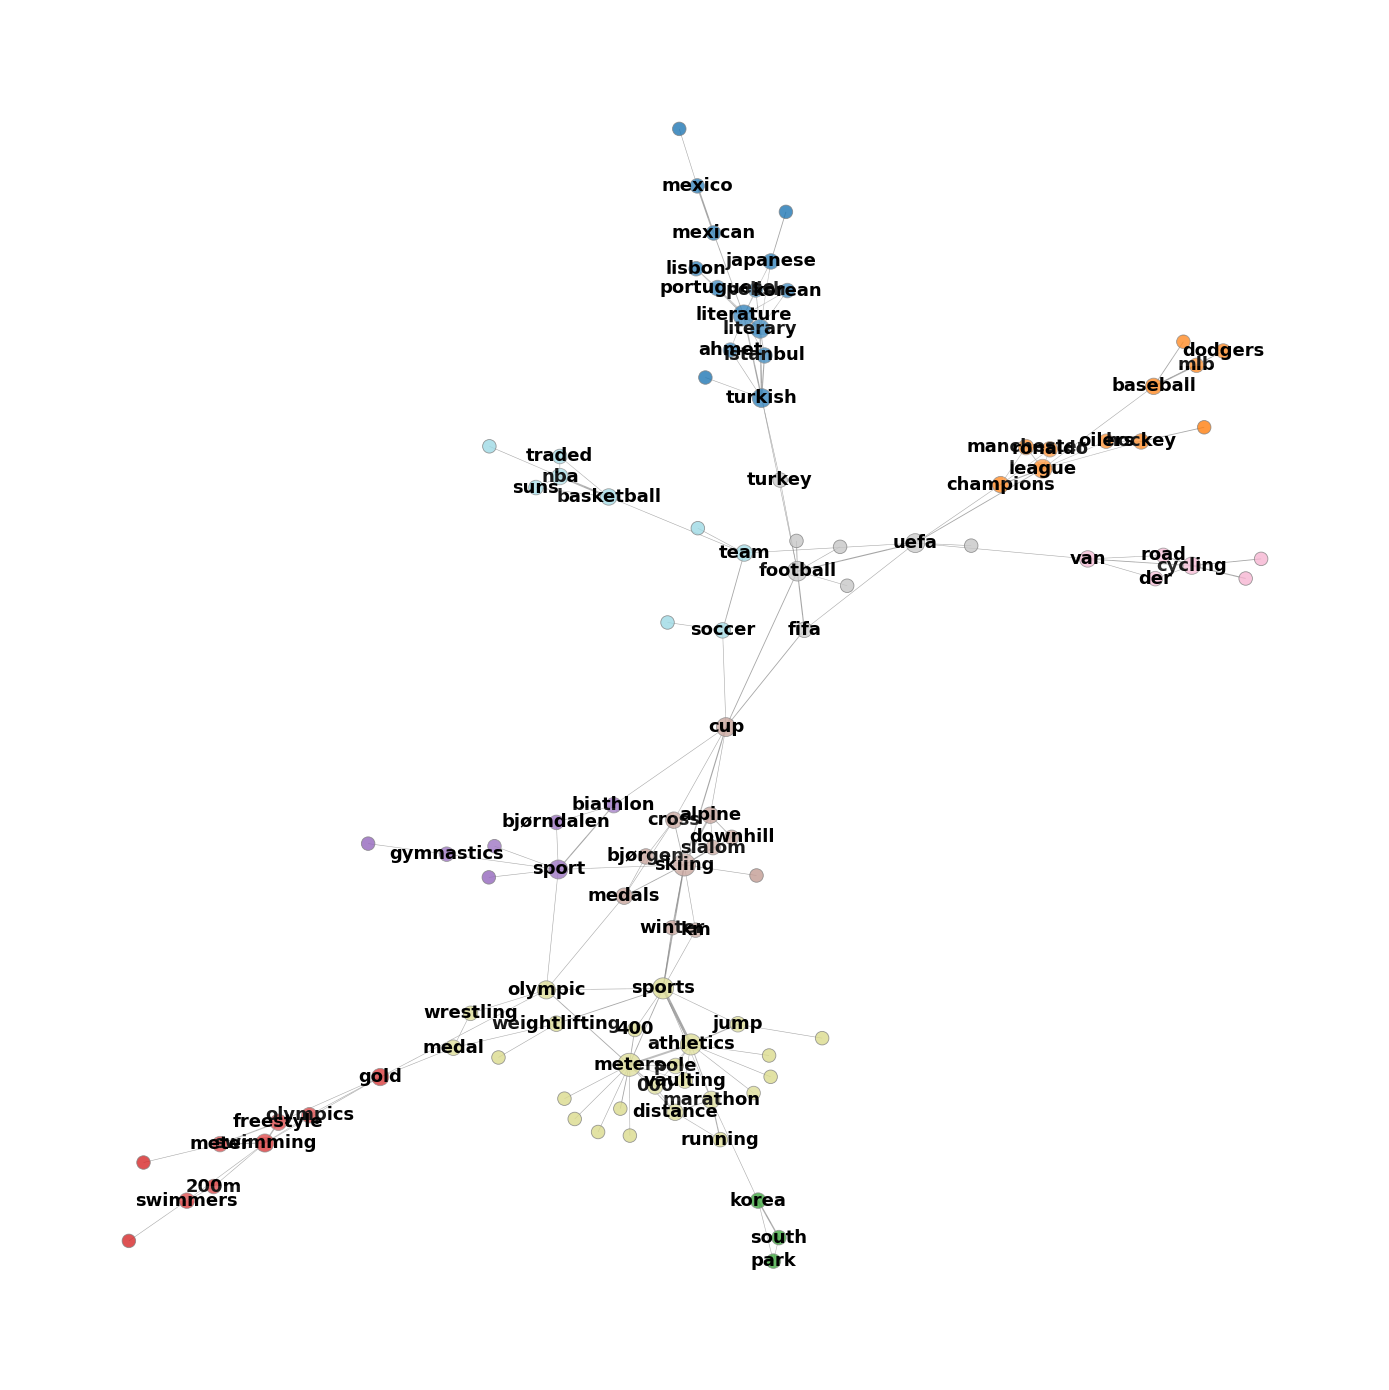

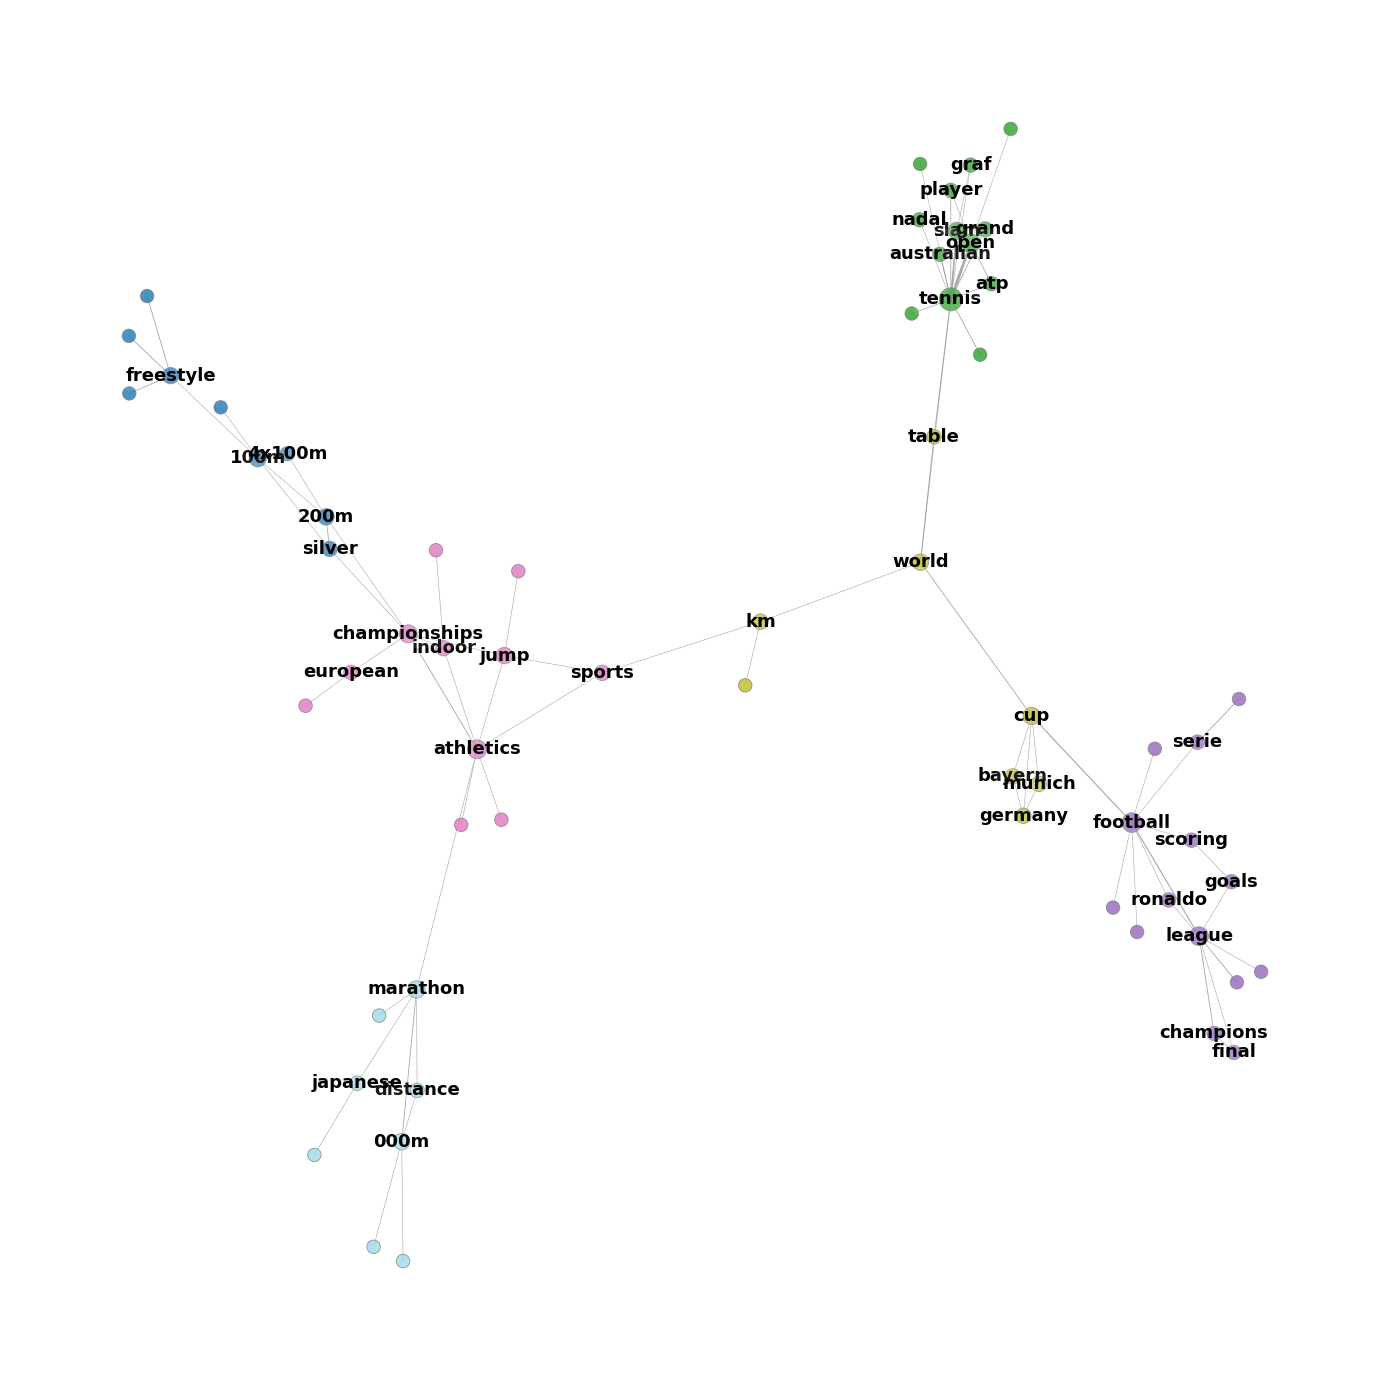

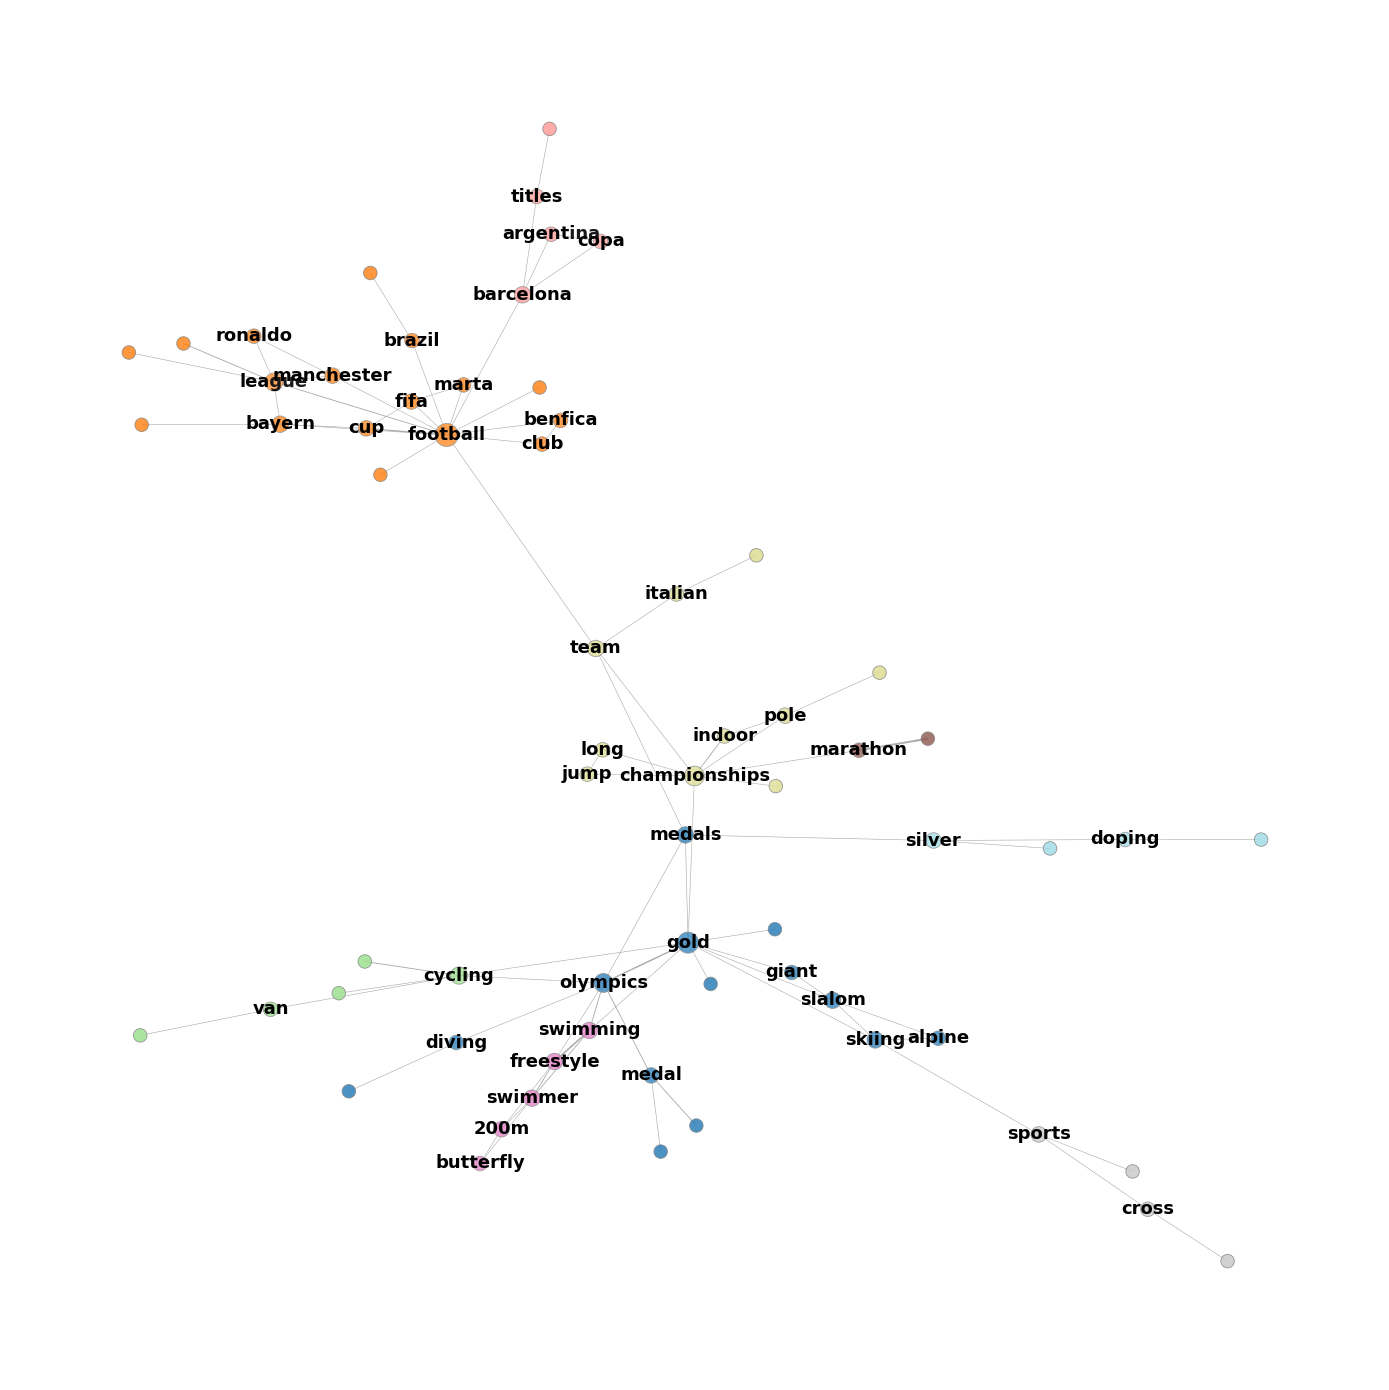

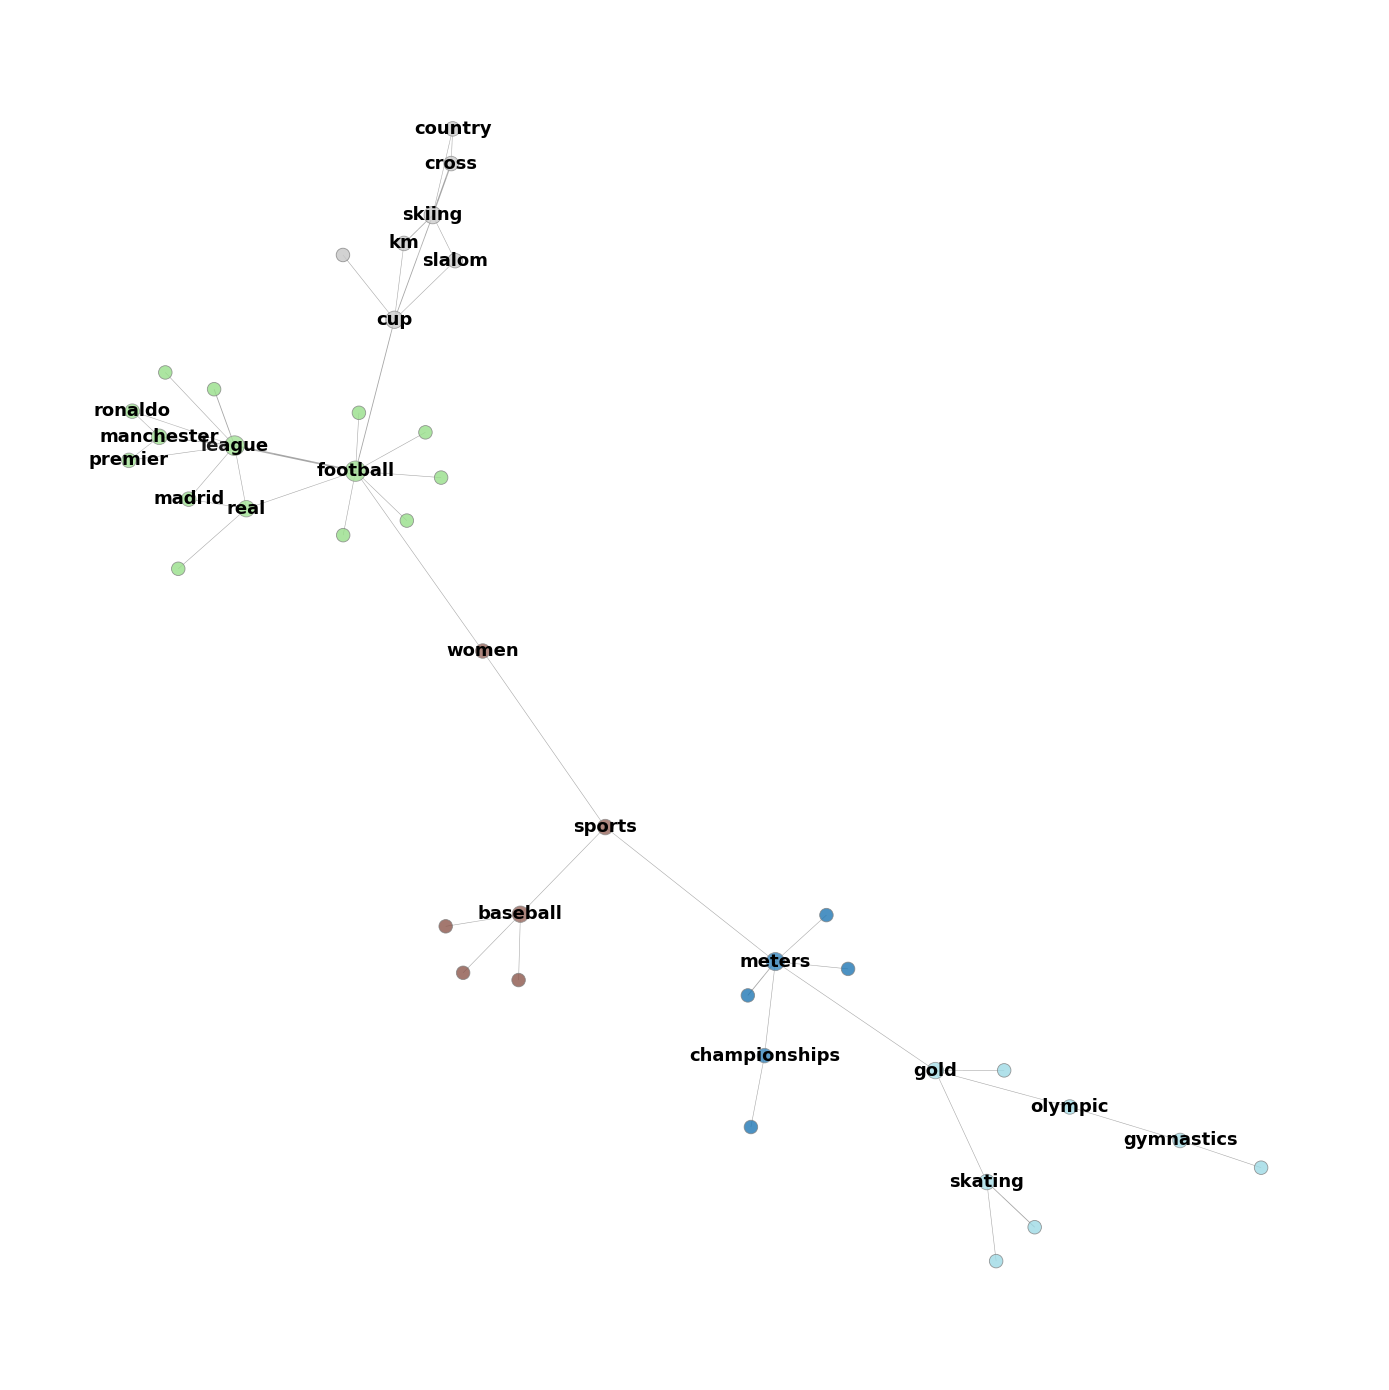

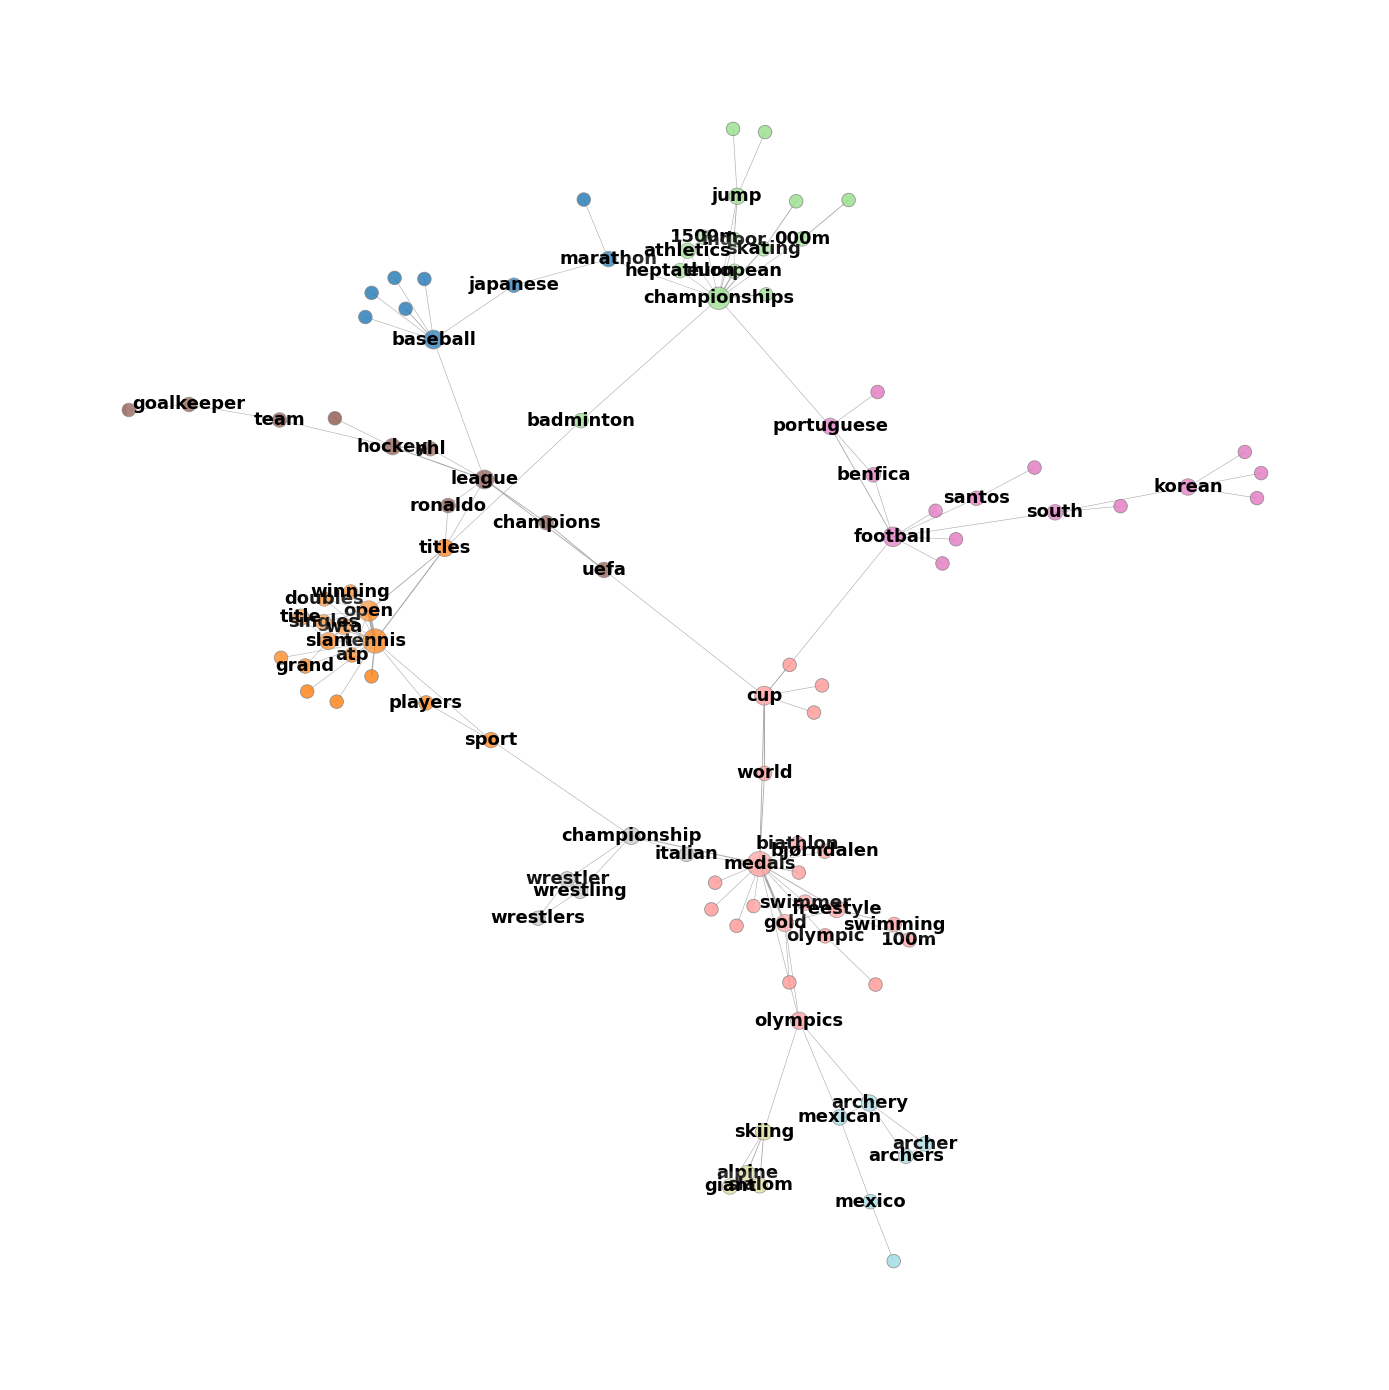

In [16]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
import community as louvain

# 1) Leer CSVs
df_scores = pd.read_csv("all_models_scores_clean.csv", encoding="utf-8")
df_bios   = pd.read_csv("../Capítulo Segundo/biografias_raw_corrected.csv", encoding="utf-8")

# 2) Unir biografías y top-5 keywords
df = pd.merge(
    df_bios,
    df_scores[["Name",
               "ChatGPT_top5_keywords",
               "DeepSeek_top5_keywords",
               "Gemini_top5_keywords",
               "Phi_top5_keywords",
               "Llama_top5_keywords",
               "Scope"]].drop_duplicates(),
    on="Name", how="inner"
)

# 3) Filtrar sólo atletas
df = df[df["Scope"] == "Athlete"].reset_index(drop=True)

# 4) Columnas de keywords
kw_cols = {
    "ChatGPT":  "ChatGPT_top5_keywords",
    "DeepSeek": "DeepSeek_top5_keywords",
    "Gemini":   "Gemini_top5_keywords",
    "Phi":      "Phi_top5_keywords",
    "Llama":    "Llama_top5_keywords"
}

def parse_kw(cell):
    return [w.strip() for w in str(cell).split(",") if w.strip()]

# 5) Extraer listas de keywords por modelo
model_kw_lists = {
    m: df[kw_cols[m]].apply(parse_kw).tolist()
    for m in kw_cols
}

# 6) Contar pares y filtrar peso>=2
model_pair_counts = {}
for m, lists in model_kw_lists.items():
    cnt = Counter()
    for kws in lists:
        for a, b in combinations(sorted(set(kws)), 2):
            cnt[(a, b)] += 1
    model_pair_counts[m] = {p: w for p, w in cnt.items() if w >= 2}

# 7) Analizar y dibujar con sólo el componente gigante
os.makedirs("output/figures/athlete_networks", exist_ok=True)
stats = []

for model, cnt in model_pair_counts.items():
    # a) Crear grafo completo
    G_full = nx.Graph()
    for (u, v), w in cnt.items():
        G_full.add_edge(u, v, weight=w)

    # b) Extraer el componente más grande
    largest_cc = max(nx.connected_components(G_full), key=len)
    G = G_full.subgraph(largest_cc).copy()

    # c) Métricas sobre G reducido
    density = nx.density(G)
    partition = louvain.best_partition(G, weight="weight")
    stats.append({
        "Model": model,
        "Density": density,
        "Communities": len(set(partition.values()))
    })

    # d) Layout más espacioso
    pos = nx.spring_layout(
        G,
        weight='weight',
        k=5,            # aumenta el “resorte” para separar más nodos
        iterations=3000,  # más iteraciones para estabilizar
        seed=42
    )

    # e) Filtrar etiquetas por grado mínimo (bájalo si quieres más)
    degrees = dict(G.degree())
    label_threshold = 2  # etiqueta también nodos de grado >= 2
    labels = {n: n for n, d in degrees.items() if d >= label_threshold}

    # f) Dibujar
    plt.figure(figsize=(14, 14))
    nx.draw_networkx_nodes(
        G, pos,
        node_size=[80 + degrees[n]*15 for n in G.nodes()],
        node_color=[partition[n] for n in G.nodes()],
        cmap='tab20', alpha=0.8,
        linewidths=0.6, edgecolors='gray'
    )
    nx.draw_networkx_edges(
        G, pos,
        width=[G[u][v]['weight']*0.2 for u, v in G.edges()],
        alpha=0.7, edge_color='gray'
    )
    nx.draw_networkx_labels(
        G, pos,
        labels=labels,
        font_size=13,           # tamaño todavía mayor
        font_color='black',
        font_weight='bold',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.1)
    )

    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"output/figures/athlete_networks/{model}_athletes_core.pdf",
                format='pdf', bbox_inches='tight')

# 8) Guardar métricas
pd.DataFrame(stats).to_csv(
    "output/csv/athlete_network_stats_core.csv",
    index=False, encoding="utf-8"
)